# 모델선택(Model Selection)

### 1) 캐글 대회를 이어서 진행합니다. RandomizedSearchCV 를 사용하여 하이퍼파라미터 튜닝을 진행합니다.

주의해야 할 점은, 이번에는 [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)를 사용한다는 점입니다.

또한 분류문제에서 맞는 [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) 같은 metric을 사용해야 합니다.

그리고 인코더 사용에도 주의 해야 하는데, 지금 다루는 분류 문제에서는 [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html)사용을 추천합니다.


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. 데이터 로드 & report를 통한 데이터 확인

In [2]:
target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [3]:
train.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state,vacc_h1n1_f
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,4,"MSA, Not Principle City",2.0,3.0,5.0,NaN,NaN,9,CALIFORNIA,0
1,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2,"MSA, Principle City",1.0,0.0,1.0,Accommodation and Food Services Industries,Food Preparation and Serving Related Occupations,7,NEBRASKA,0


In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

# 2. 데이터 EDA

### (1) h1n1_concern, h1n1_knowledge에 EDA 
 1) h1n1_concern를 value_count를 검토해본 결과, 많이 걱정함(2)와 조금 걱정이됨(1)이 60%를 넘었고 결측치(8420명)들은 20%에 해당하였다. 이에, 결측치 중에서 타겟이 1에 해당하는 분들은 2963이 이였고 그 중에 닥터의 추천을 받은 사람은 1834이였다. 그러나 해당 컬럼이 타겟과 상관관계가 높지 않으모로 최빈값으로 결측치를 대체하고자 한다. 최빈값을 주어 더욱 격차를 벌리고 싶었습니다. 
 
 
 2) 또한, h1n1_concern, h1n1_knowledge에 대한 상관관계가 낮기에 해당 COLUMN은 더하지 않도록 하겠습니다. 

In [5]:
train[(train["h1n1_concern"].isna())].shape

(8420, 39)

In [6]:
train[(train["h1n1_concern"].isna()) & (train["vacc_h1n1_f"] ==1)].shape

(2963, 39)

In [7]:
train.columns


Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_insurance',
       'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'agegrp',
       'education_comp', 'raceeth4_i', 'sex_i', 'inc_pov', 'marital',
       'rent_own_r', 'employment_status', 'census_region', 'census_msa',
       'n_adult_r', 'household_children', 'n_people_r', 'employment_industry',
       'employment_occupation', 'hhs_region', 'state', 'vacc_h1n1_f'],
      dtype='object')

In [8]:
train[(train["h1n1_concern"].isna()) & (train["doctor_recc_h1n1"] ==1)].shape

(2951, 39)

In [9]:
train[(train["h1n1_concern"].isna()) & (train["doctor_recc_h1n1"] ==1) &  (train["vacc_h1n1_f"] ==1)].shape

(1834, 39)

In [10]:
train[train["h1n1_concern"].isna()].describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,sex_i,inc_pov,marital,rent_own_r,census_region,n_adult_r,household_children,n_people_r,hhs_region,vacc_h1n1_f
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8385.000000,...,8420.000000,8420.000000,0.0,8200.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351938,...,1.490618,1.945487,NaN,2.407805,2.725891,2.114727,1.816865,3.931591,5.417221,0.351900
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.477603,...,0.499942,0.947235,NaN,10.610446,1.038935,0.669990,0.768763,0.997717,2.711913,0.477591
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,1.000000,2.000000,2.000000,1.000000,3.000000,3.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,1.000000,2.000000,NaN,1.000000,3.000000,2.000000,2.000000,4.000000,5.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,2.000000,2.000000,NaN,1.000000,4.000000,2.000000,2.000000,5.000000,8.000000,1.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,2.000000,4.000000,NaN,99.000000,4.000000,4.000000,3.000000,7.000000,10.000000,1.000000


In [11]:
train[train["h1n1_concern"].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8420 entries, 0 to 42153
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 0 non-null      float64
 1   h1n1_knowledge               0 non-null      float64
 2   behavioral_antiviral_meds    0 non-null      float64
 3   behavioral_avoidance         0 non-null      float64
 4   behavioral_face_mask         0 non-null      float64
 5   behavioral_wash_hands        0 non-null      float64
 6   behavioral_large_gatherings  0 non-null      float64
 7   behavioral_outside_home      0 non-null      float64
 8   behavioral_touch_face        0 non-null      float64
 9   doctor_recc_h1n1             8385 non-null   float64
 10  doctor_recc_seasonal         8385 non-null   float64
 11  chronic_med_condition        8299 non-null   float64
 12  child_under_6_months         0 non-null      float64
 13  health_insurance 

In [12]:
train[["h1n1_concern", "h1n1_knowledge"]].corr()

,h1n1_concern,h1n1_knowledge
h1n1_concern,1.000000,0.067425
h1n1_knowledge,0.067425,1.000000


In [13]:
train["h1n1_concern"].value_counts(normalize=True, ascending=False)

2.0    0.398441
1.0    0.305122
3.0    0.171667
0.0    0.124770
Name: h1n1_concern, dtype: float64

In [14]:
h1n1_concern_len = train["h1n1_concern"].isnull().sum()
h1n1_concern_len / len(train["h1n1_concern"])

0.19974379655548702

In [15]:
train["h1n1_knowledge"].value_counts(normalize=True, ascending=False)

1.0    0.548705
2.0    0.355783
0.0    0.095512
Name: h1n1_knowledge, dtype: float64

### (2) Behavioral EDA
 
 1) 각각의 behavioral끼리의 상관관계는 높지 않았습니다.   
 2) 해당 데이터를 꼼꼼히 읽어본 결과, 행동들의 패턴과 내용이 연관되어 있어 해당 columns을 더해주고자 합니다.

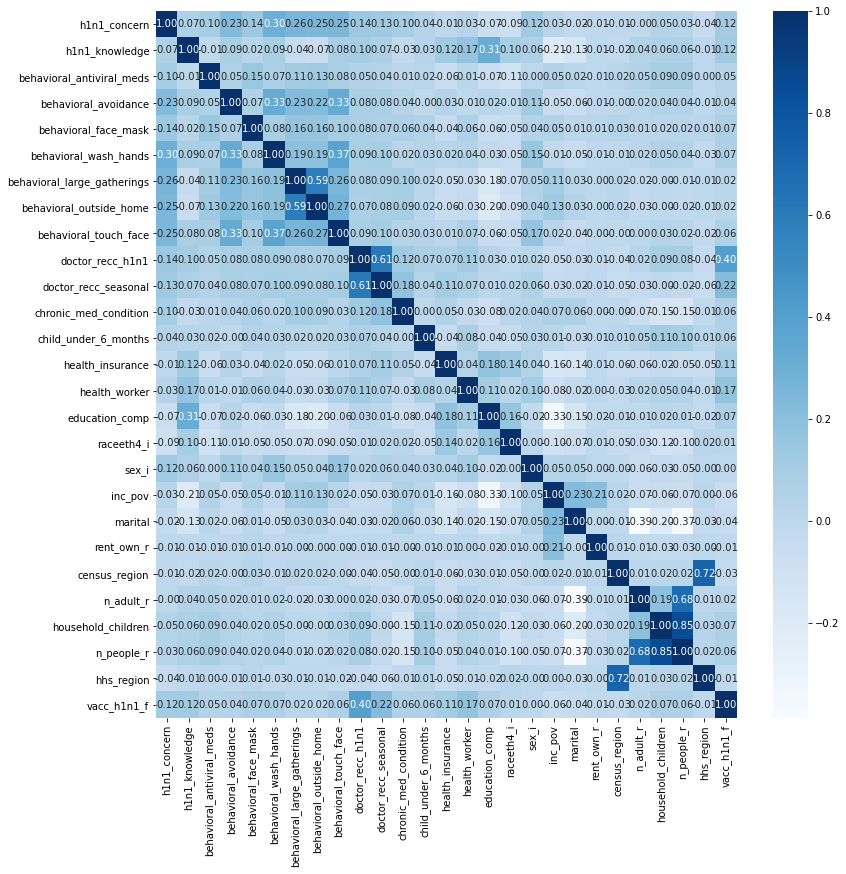

In [16]:
plt.figure(figsize=(13, 13))
corr_graphs = train.corr()
sns.heatmap(corr_graphs, annot=True, fmt=".2f", cmap="Blues");

### (3) chronic_med_condition에 대한 EDA
 
   1) 리포터에서도 확인 할 수 있듯 MISSING percentage 5% 미만이므로 무시하고 넘어가고자 한다.  
   2) 상관관계를 검토하였을 때에도 해당 데이터가 타켓을 예측하기에는 무리가 있다고 사료된다.   
   3) 일단 결측치는 0으로 대체하고자 한다. 

In [17]:
train["chronic_med_condition"].value_counts(normalize=True, ascending=False)

0.0    0.750349
1.0    0.249651
Name: chronic_med_condition, dtype: float64

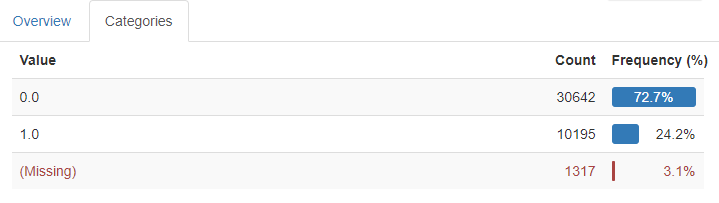

In [18]:
train["child_under_6_months"].value_counts(normalize=True, ascending=False)

0.0    0.916007
1.0    0.083993
Name: child_under_6_months, dtype: float64

### (4) health^, opinion^, agerp 에 대한 EDA

   1) health^, opinion^ 데이터에는 상관관계가 있어보이고 중첩의 효과가 있다고 사료되어 더해주고자 함   
   2) opinion^, agrep 데이터는 명목형으로 기재되어 있으나, 실제로는 순서를 가지고 있는 것으로 사료되기에 수치형으로 변환하여 사용하고자 함  

### (5) 일부 결측치가 없는 데이터들은 모두 그래도 사용하고자함 

In [19]:
print(train["raceeth4_i"].isnull().sum())
print(train["sex_i"].isnull().sum())
print(train["inc_pov"].isnull().sum())

0
0
0


### (6) education_comp, marital 등에 대한 EDA
   1) 일부 데이터에서는 결측치가 있었으나, 명확하게 해당 결측치를 찾을 수 없고, 찾는다 하여도 결과값이 다른 방향으로 유도할 수 있기에 그대로 두고 처리를 하고자 함 

### (7) census_msa에 대한 EDA
   1) MSA, Principle City에 거주하는 사람을 0으로 처리하고 
   2) 그 외 지역에 사는 사람들을 1로 처리하여 데이터를 처리하고자 함
   3) 해당 데이터는 결측치도 없고 MSA라는 명확한 기준으로 구분되어 있기에 분류를 하는데 큰 영향을 줄것으로 사료됨

In [20]:
train["census_msa"]

0        MSA, Not Principle City
1            MSA, Principle City
2        MSA, Not Principle City
3        MSA, Not Principle City
4        MSA, Not Principle City
                  ...           
42149        MSA, Principle City
42150        MSA, Principle City
42151        MSA, Principle City
42152                    Non-MSA
42153    MSA, Not Principle City
Name: census_msa, Length: 42154, dtype: object

### (8) EDA engineer function

In [21]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

#### 담당자의 EDA기준 
  1) 수치형이나 실제로는 명목형인 변수를 처리해주었습니다. 
    -. 처리시, 분류기준이 시점인지, 스타일인지 아니면 다른 어떠한 조건이 있는지를 주시하였습니다. 
  2) 명목형으로 입력되어 있으나, 실제로는 순서상의 의미를 가지는 변수를 처리해주었습니다. 
    -. 대표적인 예로 해당 데이터에서는 opinion 등이 이에 해당됩니다. 
  3) 함쳐서 하나로 만들 수 있는 변수를 처리해주었습니다. 
    -. behavioral가 이에 대표적인 예 입니다. 
  4) 결측치인지 0인데 결측치로 표시되어 있는지를 구분하여 처리해주었습니다. 
  5) 쪼갤 수 있는 것들은 나누어서 처리해주려고 하였으나, 나누는 데이터는 없었습니다. 
  6) 데이터를 살펴보고 결측치를 제거하기로 하였습니다. 
    -. 대표적인 예가 employ입니다. 
  

In [22]:
# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # h1n1_concern 결측치 처리 NaN -> 2 
    df.loc[:, "h1n1_concern"] = df.loc[:, "h1n1_concern"].fillna(2)
    
    
    # h1n1_knowledge 결측치 처리 NaN -> 1
    df.loc[:, "h1n1_knowledge"] = df.loc[:, "h1n1_knowledge"].fillna(1)
    
    
    # behaviorals에 대한 EDA
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)    

    
    # chronic_med_condition 결측치 처리 NaN -> 0
    df.loc[:, "chronic_med_condition"] = df.loc[:, "chronic_med_condition"].fillna(0)
    
    
#     해당 eda는 성적을 떨어트는 것으로 간주되어 주석처리
#     # healthss에 대한 EDA
#     df.loc[:, "health_insurance"] = df.loc[:, "health_insurance"].fillna(1)
#     df.loc[:, "health_worker"] = df.loc[:, "health_worker"].fillna(0)
#     healths = [col for col in df.columns if 'health' in col] 
#     df['healths'] = df[healths].sum(axis=1)    
    
    
    # opinion에 대한 EDA
    for column_opinion in [col for col in df.columns if 'opinion' in col]:
        df[column_opinion] = df[column_opinion].replace('Not at all effective',0).replace('Not Very Effective',1).replace('Don\'t know',2).replace('Somewhat effective',3).replace('Very effective',4)
        df[column_opinion] = df[column_opinion].replace('Very Low',0).replace('Somewhat low',1).replace('Don\'t know',2).replace('Somewhat high',3).replace('Very high',4)
        df[column_opinion] = df[column_opinion].replace('Not at all worried',0).replace('Not very worried',1).replace('Don\'t know',2).replace('Somewhat worried',3).replace('Very worried',4)    
    opinions = [col for col in df.columns if 'opinion' in col] 
    
    
#     해당 eda는 성적을 떨어트는 것으로 간주되어 주석처리    
#     #agegrp에 대한 EDA
#     df['agegrp'] = df['agegrp'].replace('6 Months - 9 Years',1).replace('10 - 17 Years',2).replace('18 - 34 Years',3).replace('35 - 44 Years',4).replace('45 - 54 Years',5).replace('55 - 64 Years',6).replace('65+ Years',7)
   

    #census_msa에 대한 EDA
    df["census_msa"] = df["census_msa"].replace("MSA, Not Principle City",1)
    df["census_msa"] = df["census_msa"].replace("MSA, Principle City",1)
    df["census_msa"] = df["census_msa"].replace("Non-MSA",1)
 
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    df = df[selected_features]



    dels = [col for col in df.columns if ('employment' in col in col)]
#     dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
# EDA 결과 확인
train.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,vacc_h1n1_f,behaviorals
20365,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1,1,4.0,0.0,4.0,2,0,0.0
29138,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2,1,2.0,2.0,4.0,7,1,5.0


In [24]:
train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_insurance',
       'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'agegrp',
       'education_comp', 'raceeth4_i', 'sex_i', 'inc_pov', 'marital',
       'rent_own_r', 'census_region', 'census_msa', 'n_adult_r',
       'household_children', 'n_people_r', 'hhs_region', 'vacc_h1n1_f',
       'behaviorals'],
      dtype='object')

# 2. 분석기법을 통한 분석

### (0) 전일 제출 과제 모델 & 교차검증을 적용한 모델 비교

In [25]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42, n_jobs=-1, oob_score=True)
)

pipe.fit(X_train, y_train)
print('교체 검증 미포함한 정확도', pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)

# -------------------------------------------------------------

k = 10
scores = cross_val_score(pipe, X_train, y_train, cv=k)


print('교체 검증 포함한 정확도', scores.mean())

교체 검증 미포함한 정확도 0.8106986122642629
교체 검증 포함한 정확도 0.8064821330789934


### (1) 교차검증만 사용

In [26]:
# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')

features = train.drop(columns=[target]).columns

# 훈련을 위한 데이터 분류
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    SelectKBest(f_regression, k=20), 
    Ridge(alpha=1.0)  
)

k = 3

# 1. 이래 코드는 cross_val_score를 사용하는 코드인데
# 2. 1번 변수는 어떤 모델을 사용할지 
# 3. 2, 3번 변수는 어떤 데이터를 사용하는지 
# 4. cv는 몇번 교차검증을 진행할 것인지 
# scoring은 없어도 되는데 회귀에서 음수 스코어 값을 설정해주기 위한 코드이다. 
scores = cross_val_score(pipe, X_train, y_train, cv=k)

#scores = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')


print('교체 검증 포함한 정확도', scores.mean())

교체 검증 포함한 정확도 0.20434317960806514


### (2) 랜덤포레스트 적용

In [27]:
# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')

features = train.drop(columns=[target]).columns

# 훈련을 위한 데이터 분류
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    SelectKBest(f_regression, k=20), 
    RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)
)

k = 3

# 1. 이래 코드는 cross_val_score를 사용하는 코드인데
# 2. 1번 변수는 어떤 모델을 사용할지 
# 3. 2, 3번 변수는 어떤 데이터를 사용하는지 
# 4. cv는 몇번 교차검증을 진행할 것인지 
# scoring은 없어도 되는데 회귀에서 음수 스코어 값을 설정해주기 위한 코드이다. 
scores = cross_val_score(pipe, X_train, y_train, cv=k)

#scores = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')


print('교체 검증 포함한 정확도', scores.mean())

교체 검증 포함한 정확도 0.2826033214883295


# 3. 최적의 하이퍼파라미터 찾기(RandomizedSearchCV)

In [44]:
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(OrdinalEncoder(), SimpleImputer(), 
                             RandomForestClassifier(criterion='entropy',
                                                    n_jobs=-1,
                                                    oob_score=True
                                                    )
  )

parameters = {'randomforestclassifier__n_estimators': [100, 500, 1000], 
               'randomforestclassifier__min_samples_leaf': [5,10,15],
              'randomforestclassifier__max_depth': [5,10,15]}


clf = RandomizedSearchCV(
    pipe, 
    param_distributions=parameters, 
    n_iter=50, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.4min finished


In [45]:
print('최적 하이퍼파라미터: ', clf.best_params_)

최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_depth': 15}


In [46]:
# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,18,19,20,23,22,24,21,25,26,11,...,17,0,3,7,6,5,8,1,2,4
mean_fit_time,3.71499,16.8745,30.6417,22.8077,14.7832,4.67303,4.24119,13.9875,14.6932,28.297,...,26.9291,1.51602,4.39748,10.9572,4.14174,23.555,20.7454,13.2034,22.4865,14.4783
std_fit_time,0.922853,1.60468,0.56451,1.9755,1.57784,1.31108,0.858971,0.378607,0.953589,0.896672,...,2.62928,0.277001,1.28863,0.908407,1.38979,1.65704,2.8503,0.259208,0.195052,0.637589
mean_score_time,2.05721,1.45998,0.553521,0.49044,1.97495,1.43598,1.83482,0.220527,0.352642,2.34944,...,1.56813,1.90575,2.49127,1.07863,0.988896,2.38632,0.993249,0.507818,1.49869,0.378341
std_score_time,0.921589,0.291168,0.0832735,0.0380939,0.967959,0.807157,2.26504,0.011963,0.057428,0.316728,...,0.805782,1.50434,0.837783,0.659413,1.24706,0.843929,0.0805765,0.0236282,0.199136,0.0178668
param_randomforestclassifier__n_estimators,100,500,1000,1000,500,100,100,500,1000,1000,...,1000,100,100,500,100,1000,1000,500,1000,500
param_randomforestclassifier__min_samples_leaf,5,5,5,10,10,15,10,15,15,5,...,15,5,10,15,15,10,15,5,5,10
param_randomforestclassifier__max_depth,15,15,15,15,15,15,15,15,15,10,...,10,5,5,5,5,5,5,5,5,5
params,"{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 1000,...",...,"{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 500, ...","{'randomforestclassifier__n_estimators': 1000,...","{'randomforestclassifier__n_estimators': 500, ..."
split0_test_score,0.541011,0.538716,0.535496,0.52944,0.528031,0.535975,0.526417,0.526468,0.525604,0.522689,...,0.515337,0.40221,0.398448,0.398893,0.4,0.404854,0.403088,0.400332,0.401436,0.399557
split1_test_score,0.534293,0.536585,0.536048,0.524375,0.525115,0.519921,0.526747,0.520568,0.520147,0.515449,...,0.506317,0.403514,0.403619,0.410383,0.427957,0.400221,0.395349,0.403297,0.396795,0.396347


In [47]:
# 만들어진 모델에거 가장 성능이 좋은 모델을 불러옵니다.
pipe = clf.best_estimator_

In [52]:
scores_before = cross_val_score(pipe, X_train, y_train)
scores_after = cross_val_score(pipe, X_val, y_val)

print('정확도', scores_before.mean())
print('정확도', scores_after.mean())

정확도 0.8241852846491448
정확도 0.8268296884767403


In [53]:
scores = cross_val_score(pipe, X_val, y_val, cv=3)
y_pred = pipe.predict(X_test)
y_pred
y_pred[y_pred >=0.25] = 1
y_pred[y_pred <0.25] = 0


In [54]:
y_pred
final_pred = y_pred.astype(int)

In [55]:
sample_submission
sample_submission["vacc_h1n1_f"] = final_pred
sample_submission.to_csv("submission.csv", index=False)

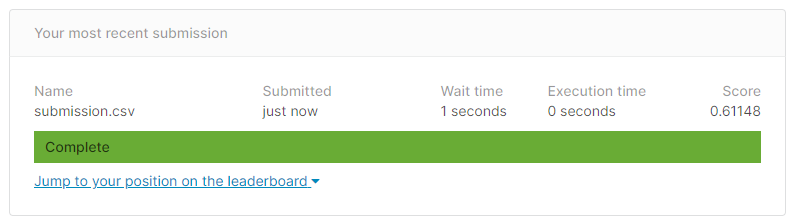

### 2) (도전과제🔥) [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 를 사용하여 하이퍼파라미터 튜닝을 진행합니다.

In [56]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, 
                           max_depth=15, 
                           max_features=0.4, 
                           min_samples_leaf=15, 
                           random_state=42, 
                           n_jobs=-1, 
                           oob_score=True)
)

pipe.fit(X_train, y_train)

k = 5
scores = cross_val_score(pipe, X_train, y_train, cv=k)


print('교체 검증 포함한 정확도', scores.mean())

교체 검증 포함한 정확도 0.8254307834897252


In [58]:
scores_after = cross_val_score(pipe, X_val, y_val, cv=k)
y_pred = pipe.predict(X_test)

print('정확도', scores_after.mean())

정확도 0.8258807670969335


점수 : 0.615로 상승 -> 과적합이 된게 아닐까 고민해보았습니다.

In [59]:
sample_submission
sample_submission["vacc_h1n1_f"] = y_pred
sample_submission.to_csv("submission.csv", index=False)

# 결과 보고 


  1) h1n1_knowledge 를 feature 엔지니어링을 했을때 점수가 계속 떨어지는 것이 관측되었습니다.   
  2) 이에, 본연의 데이터가 가장 큰 영향을 주는 것으로 사료됩니다.   
  3) health_insurance, health_worker도 본 데이터가 결과에 영향을 더 주는 것으로 관측되었습니다.   
  4) behavioral가 들어간 컬럼의 sum한 feature을 테스트한 결과 확실한 behavioral에 대한 컬럼을 더해주었을 더욱 점수가 상승하는 것을 관측할 수 있었습니다. 상호간의 시너즈효과를 볼 수 있는 대표적인 컬럼이었습니다.   
  5) opinion에 대한 컬럼 또한 명목형이나 숫자로 치환해주었을 때 더욱 점수가 상승되는 것을 확인하였습니다.  
  6) 스코어는 확실히 하이퍼파라미터의 영향을 많이 받는 것으로 관측되었습니다. 특히 해당 데이터에서는 트리갯수를 더욱 늘릴 수록 향상되는 것을 관측 할 수 있었습니다. 
  이상입니다. 

# 과제 회고

우태님께서는 이러한 결과보고서형 EDA를 원하셨던 걸로 파악이 됩니다.   
단순히 점수만이 아니라 데이터에 대한 진지한 고찰이 느껴지는지를 확인하고 싶으셨다고 생각이 들었습니다.   
그런데 저는 생각이 조금 달랐습니다.  하이퍼파라미터를 모두 배운 후 최대 스코어를 뽑은 후 EDA를 진행하는 것이 맞다라고 저는 생각을 하였습니다.  
또한, 현재 배우고 있는 모든 스킬들도 정확히 이해가 되지 않고 사용법도 파악이 되지 않는 상황에서 EDA 집중을 하기에는 매우 어려웠습니다. 또한, 그로 인해 점수도 저평가되는 부분에서 속상하기도 하였습니다.  
그러나, 언제가 스님은 절의 규칙을 따라야하지 않을까? 진지하게 고민을 하고 모든 상황을 있는 그대로 받아드리고 저의 실력을 더 키우기로 하였습니다.  
멘탈 상담을 진행할까? 하였지만, 전반적인 상황을 모두 고민 후 더욱더 열심히 공부하기로 마음 먹었습니다.  
향후 과제에서는 더욱 진지하게 데이터를 분석토록 하겠습니다.  
감사합니다.  